## Strategies Investigation Notebook 1

#### So far this program investigates the potential exposure of each strategy via. Monte Carlo Simulation, and also investigates the percentage in growth from the brute force approach for each method!

### SETUP: Define all the programs we will use

#### Step 1: Import Modules

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import scipy
from scipy.stats import chisquare
import sys

#### Step 3: Define the 4 different strategies 

In [2]:
def PSR_NGR(positions, addonfactor, singleposition):

    GrossExposure = 0
    CurrentExposure = 0
    NetExposure = 0
    AddOn_Gross = 0

    if singleposition == True:
        GrossExposure += max(0, positions[0])
        CurrentExposure += positions[0]
        AddOn_Gross += addonfactor * positions[1]
    else:
        for i in range(len(positions)):
            GrossExposure += max(0, positions[i,0])
            CurrentExposure += positions[i,0]
            AddOn_Gross += addonfactor * positions[i,1]

    NetExposure = max(0, CurrentExposure)

    if GrossExposure == 0:
        NGR = 0
    else:
        NGR = NetExposure/GrossExposure
    
    PSR = max(0, CurrentExposure) + NGR * (0.6) * (AddOn_Gross) + (0.4) * (AddOn_Gross)

    return PSR



def PSR_Conservative(positions, addonfactor):

    total_PSR_NGR = 0
    singleposition = True

    for i in range(len(positions)):
        total_PSR_NGR += PSR_NGR(positions[i,:], addonfactor, singleposition)
    
    return total_PSR_NGR

def PSR_Linear(positions, addonfactor):

    total_PSR_NGR = 0

    base_PSR_NGR = 0
    singleposition = True
    sample = positions[0,:]
    base_PSR_NGR += PSR_NGR(sample, addonfactor, singleposition)
    total_PSR_NGR = base_PSR_NGR

    singleposition = False

    for i in range(len(positions)-1):
        total_PSR_NGR += (PSR_NGR(positions[[0,i+1], :], addonfactor, singleposition) - base_PSR_NGR)

    return total_PSR_NGR


def PSR_Average(positions, addonfactor, n):

    total_PSR_NGR = 0
    base_PSR_NGR = 0

    singleposition = True
    base_PSR_NGR += PSR_NGR(positions[0,:], addonfactor, singleposition)
    total_PSR_NGR = base_PSR_NGR

    singleposition = False

    for i in range(len(positions)-1):

        # take out the baseline position and the x_i position
        trade_i = positions[[0,i+1], :]
        
        # multiply the i-th position by n - as it happens in the formula
        trade_i[1,:] *= n

        # multiply the formula by n
        total_PSR_NGR += 1/n*(PSR_NGR(trade_i, addonfactor, singleposition) - base_PSR_NGR)


    return total_PSR_NGR

In [3]:
# TEST 1: PSR_NGR = 30.765 , PSR_BruteForce = 30.9
'''    
positions = np.zeros((4,2))

positions[0,0] = 10
positions[1,0] = 20
positions[2,0] = -10
positions[3,0] = 10


positions[0,1] = 20
positions[1,1] = 40
positions[2,1] = 10
positions[3,1] = 20
'''


# TEST 1: PSR_NGR = 30.765 , PSR_BruteForce = 30.9
'''    
positions = np.zeros((4,2))

positions[0,0] = 10
positions[1,0] = 20
positions[2,0] = -10
positions[3,0] = 10


positions[0,1] = 20
positions[1,1] = 40
positions[2,1] = 10
positions[3,1] = 20
'''

# Randomly generated set of [MTM, Notional]
    # TEST 1A
'''
positions = np.zeros((2,2))

positions[0,0] = 10
positions[1,0] = 20

positions[0,1] = 20
positions[1,1] = 40
'''

# TEST 2: PSR_NGR = 15.51 , PSR_BruteForce = 15.6

'''
positions = np.zeros((3,2))

positions[0,0] = 10
positions[1,0] = -5
positions[2,0] = 10

positions[0,1] = 20
positions[1,1] = 10
positions[2,1] = 30
'''

'\npositions = np.zeros((3,2))\n\npositions[0,0] = 10\npositions[1,0] = -5\npositions[2,0] = 10\n\npositions[0,1] = 20\npositions[1,1] = 10\npositions[2,1] = 30\n\n\n'

In [4]:
def main(n, baseline_mtm):

    # Randomly generated set of [MTM, Notional]
    positions = np.zeros((n, 2))

    positions[0, 0] = baseline_mtm
    positions[0, 1] = 1000

    for i in range(len(positions) - 1):
        positions[i + 1, 0] = random.randint(-10, 10)
        positions[i + 1, 1] = abs(5 * positions[i, 0])

    addonfactor = 0.01
    singleposition = False

    # Initialize cumulative PSR values and lists
    cumulative_positions = np.zeros((0, 2))  # empty to start
    bf_list = []
    lin_list = []
    cons_list = []
    avg_list = []

    for j in range(len(positions)):

        # Add the next position to the cumulative set
        cumulative_positions = np.vstack([cumulative_positions, positions[j, :]])

        # Perform the PSR calculations for each strategy
        NGR_BF = PSR_NGR(cumulative_positions, addonfactor, singleposition)
        NGR_Lin = PSR_Linear(cumulative_positions, addonfactor)
        NGR_Cons = PSR_Conservative(cumulative_positions, addonfactor)
        NGR_Avg = PSR_Average(cumulative_positions, addonfactor, j + 1)

        # Append results to respective lists
        bf_list.append(NGR_BF)
        lin_list.append(NGR_Lin)
        cons_list.append(NGR_Cons)
        avg_list.append(NGR_Avg)
    
    print(positions)
    print("BF: ", bf_list)
    print("Lin: ", lin_list)
    print("Cons: ", cons_list)
    print("Avg: ", avg_list)

    # Check final PSR values for the full positions matrix
    final_BF = PSR_NGR(positions, addonfactor, singleposition)
    final_Lin = PSR_Linear(positions, addonfactor)
    final_Cons = PSR_Conservative(positions, addonfactor)
    final_Avg = PSR_Average(positions, addonfactor, len(positions))

    # Compare the final entry of the lists to the full-set PSR values
    print("\nFinal PSR NGR for Brute Force: ", final_BF)
    print("\nFinal PSR NGR for Linearisation: ", final_Lin)
    print("\nFinal PSR NGR for Conservative: ", final_Cons)
    print("\nFinal PSR NGR for Averages: ", final_Avg)

    return [positions, addonfactor, bf_list, lin_list, cons_list, avg_list]


# Run the simulation
[positions, addonfactor, bf_list, lin_list, cons_list, avg_list] = main(100, 100)



[[ 100. 1000.]
 [   0.  500.]
 [   8.    0.]
 [   7.   40.]
 [  -6.   35.]
 [   6.   30.]
 [   1.   30.]
 [   5.    5.]
 [  -7.   25.]
 [  -1.   35.]
 [   7.    5.]
 [  -9.   35.]
 [  -5.   45.]
 [   1.   25.]
 [  -1.    5.]
 [  -9.    5.]
 [  -5.   45.]
 [   6.   25.]
 [   4.   30.]
 [  -2.   20.]
 [   6.   10.]
 [  -6.   30.]
 [   5.   30.]
 [   0.   25.]
 [   2.    0.]
 [  -4.   10.]
 [  -4.   20.]
 [  -9.   20.]
 [  -8.   45.]
 [   1.   40.]
 [  -1.    5.]
 [  -7.    5.]
 [   7.   35.]
 [  -6.   35.]
 [   2.   30.]
 [   1.   10.]
 [  10.    5.]
 [  -5.   50.]
 [  -3.   25.]
 [  -6.   15.]
 [  -6.   30.]
 [   8.   30.]
 [   6.   40.]
 [   1.   30.]
 [   6.    5.]
 [   6.   30.]
 [  -2.   30.]
 [ -10.   10.]
 [  -9.   50.]
 [  -1.   45.]
 [   8.    5.]
 [  -5.   40.]
 [   0.   25.]
 [   7.    0.]
 [   0.   35.]
 [   3.    0.]
 [  -9.   15.]
 [  -9.   45.]
 [   8.   45.]
 [  -9.   40.]
 [  -7.   45.]
 [ -10.   35.]
 [  -9.   50.]
 [  -2.   45.]
 [  -6.   10.]
 [  -2.   30.]
 [  -7.   

### NB: Set up Baseline Position and Incoming Trades 

In [5]:
# BASELINE POSITION
MarkToMarket = 100
Notional = 1000


# For the incoming positions , we simply set the range of the values used for sampling incoming trades
MTM_Min = -10
MTM_Max = 10


# For simplicity, we set the AddOnFactor to be the same for all the trades
addOnFactor = 0.01

#### Step 5: Generate the dataset: Baseline Position + Incoming Trades

In [6]:
def get_position_impacts(n, MarkToMarket, Notional, MTM_Min, MTM_Max):
    
    baseline_position = [MarkToMarket, Notional]
    #baseline_position = [63000, 200]
    mtm_notional_matrix = np.zeros((n,2))

    
    for i in range(n):

        mtm_notional_matrix[i,0] = random.randint(MTM_Min,MTM_Max)
        mtm_notional_matrix[i,1] = abs(mtm_notional_matrix[i,0])*10
        
        #mtm_notional_matrix[i,0] = random.randint(-2000,3000)
        #mtm_notional_matrix[i,1] = random.randint(-1000,1000)
        
    positions = np.vstack([baseline_position, mtm_notional_matrix])
    return positions

#### Step 6: Calculate Mean and Variance of the respective methods by analysing the distribution of values at 100th trade

In [7]:
def get_mean_variance(final_vals, samples):
    
    mu = []
    sigma = []
    std = []

    for i in range(final_vals.shape[0]):
        mu.append(np.sum(final_vals[i,:])/samples)

        current_mu = np.sum(final_vals[i,:])/samples

        std.append(np.std(final_vals[i,:]))

        diff_squared = np.sum((final_vals[i,:] - current_mu) ** 2)
        sigma.append(diff_squared / samples)
        
    return [mu,sigma, std]

#### Step 6a: Clean data by rounding float numbers to 4 decimal places

In [8]:
def remove_decimal_places(my_list):
    new_list = list(np.around(np.array(my_list), 4))
    return new_list

### PART 1: Monte Carlo Simulation of the strategies
#### In our first simulation, we investigate the distribution of the exposure strategies.
#### We generate a random dataset (baseline + positions) and input it into each exposure calculator. We repeat this process multiple times to get a distribution. 

#### Step 7: The big part: Simluate the exposure calculations using Monte Carlo

In [9]:
def exposure_simulation1(n, samples, addOnFactor, widget, MarkToMarket, Notional, MTM_Min, MTM_Max):

    x = np.linspace(0,n+1,n+1)
    final_vals = np.zeros((4,samples))

    fig,axs = plt.subplots(2,2, figsize=(10,8))
    fig.subplots_adjust(hspace=0.5) 
    fig.subplots_adjust(wspace=0.5) 

    singleposition = False
    
    for i in range(samples):
    # Initialize cumulative PSR values and lists
        positions = get_position_impacts(n, MarkToMarket, Notional, MTM_Min, MTM_Max)
        cumulative_positions = np.zeros((0, 2))  # empty to start
        bf_list = []
        lin_list = []
        cons_list = []
        avg_list = []

        for j in range(len(positions)):

            # Add the next position to the cumulative set
            cumulative_positions = np.vstack([cumulative_positions, positions[j, :]])

            # Perform the PSR calculations for each strategy
            NGR_BF = PSR_NGR(cumulative_positions, addonfactor, singleposition)
            NGR_Lin = PSR_Linear(cumulative_positions, addonfactor)
            NGR_Cons = PSR_Conservative(cumulative_positions, addonfactor)
            NGR_Avg = PSR_Average(cumulative_positions, addonfactor, j+1)

            # Append results to respective lists
            bf_list.append(NGR_BF)
            lin_list.append(NGR_Lin)
            cons_list.append(NGR_Cons)
            avg_list.append(NGR_Avg)
        
        #print("BF: ", bf_list[-1])
        #print("Lin: ", lin_list[-1])
        #print("Avg: ",avg_list[-1])
        #print("Cons: ", cons_list[-1])
        
        axs[0,0].plot(x,bf_list, c='r', label="Brute Force")
        axs[0,1].plot(x,lin_list, 'g', label="Linearisation")
        axs[1,0].plot(x,cons_list, 'b', label="Conservative")
        axs[1,1].plot(x,avg_list, 'y', label="Averages")
        

        final_vals[0,i] = bf_list[-1]
        final_vals[1,i] = lin_list[-1]
        final_vals[2,i] = cons_list[-1]
        final_vals[3,i] = avg_list[-1]


    axs[0,0].set_xlabel("Trade Number")
    axs[0,0].set_ylabel("Exposure")

    axs[1,0].set_xlabel("Trade Number")
    axs[1,0].set_ylabel("Exposure")

    axs[0,1].set_xlabel("Trade Number")
    axs[0,1].set_ylabel("Exposure")

    axs[1,1].set_xlabel("Trade Number")
    axs[1,1].set_ylabel("Exposure")
    
    axs[0,0].set_title("Brute Force")
    axs[0,1].set_title("Linearisation")
    axs[1,0].set_title("Conservative")
    axs[1,1].set_title("Averages")

    plt.show()
    
    if widget == False:
        return final_vals
    else:
        return None    


#### Step 8: Run the functions above, analyse the graphs, and inspect mean and variance of each method

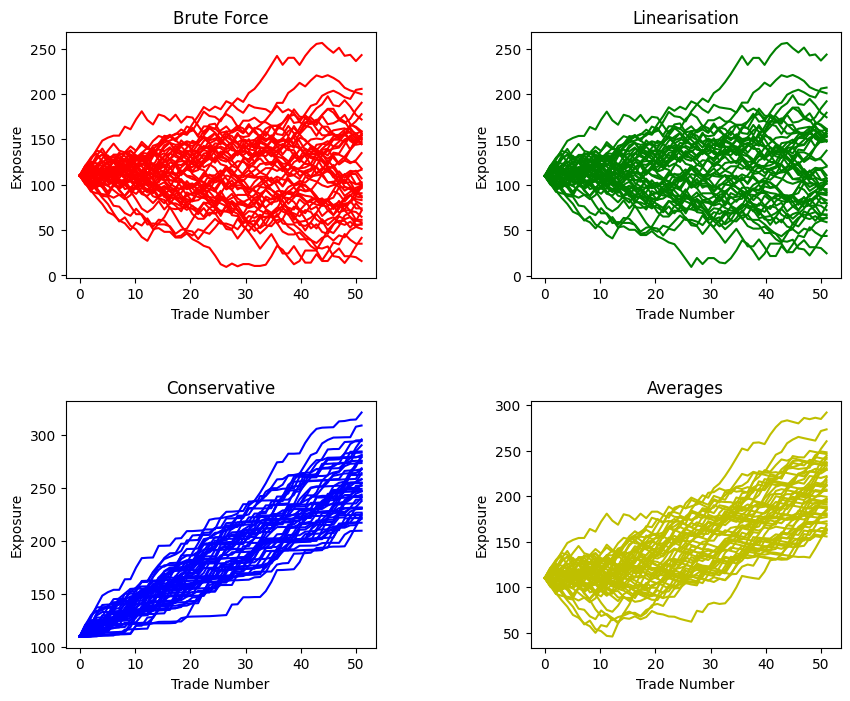

Entries below will correspond as follows : [Brute Force, Linearisation, Conservative, Averages]
Average Values at trade 100:  [115.2013, 119.7723, 255.64, 206.5905]
Variance at trade 100:  [2376.2359, 2191.4443, 667.0179, 1013.7114]
Standard Deviation at trade 100:  [48.7467, 46.8129, 25.8267, 31.8388]


In [10]:
samples = 50
n = 50
addonfactor = 0.01

final_vals = exposure_simulation1(n, samples, addOnFactor, False, MarkToMarket, Notional, MTM_Min, MTM_Max)

[mu,sigma,std] = get_mean_variance(final_vals, samples)


print("Entries below will correspond as follows : [Brute Force, Linearisation, Conservative, Averages]")
print("Average Values at trade 100: ", remove_decimal_places(mu))
print("Variance at trade 100: ", remove_decimal_places(sigma))
print("Standard Deviation at trade 100: ", remove_decimal_places(std))

#### INTERACT
##### Toggle the sliders below to investigate the growth rates yourself!

In [11]:
widgets.interact(exposure_simulation1, 
         n = widgets.IntSlider(min = 20 , max = 400, step = 1, value=100, description="No. of Trades"),
         samples = widgets.IntSlider(min=0,max=500,step=20,value=200,description="No. of Samples"),
         addOnFactor = widgets.FloatSlider(min=0, max = 1, value=0.01, step = 0.01, description="addOnFactor"),
         widget = True,         
         MarkToMarket = widgets.IntSlider(min=0,max=10000,step=100,value=1000,description="Base MTM"),
         Notional = widgets.IntSlider(min=0,max=1000000,step=1000,value=100000,description="Base Notional"),
         MTM_Min = widgets.IntSlider(min=-1000,max=-100,step=10,value=-10,description="MTM Min"),
         MTM_Max = widgets.IntSlider(min=100,max=1000,step=10,value=10,description="MTM Max"), 
)

interactive(children=(IntSlider(value=100, description='No. of Trades', max=400, min=20), IntSlider(value=200,…

<function __main__.exposure_simulation1(n, samples, addOnFactor, widget, MarkToMarket, Notional, MTM_Min, MTM_Max)>

#### Step 8a: This is purely for fun, but we can show that the conservative approach follows an Arithmetic Brownian Motion (ABM). All we need to do is calculate the mean and standard deviation of Y = max(0,X) + 0.1*abs(X)

Mean of distribution: 2.9988825428618027  Standard Deviation of distribution: 3.352219755439138


mu =  2.9988825428618027
sigma =  3.352219755439138
Distribution of trades at trade 100 --> N( mu * t + X_0 , sigma^2 * t ) = N( 259.9441271430901 , 561.8688644378218 )


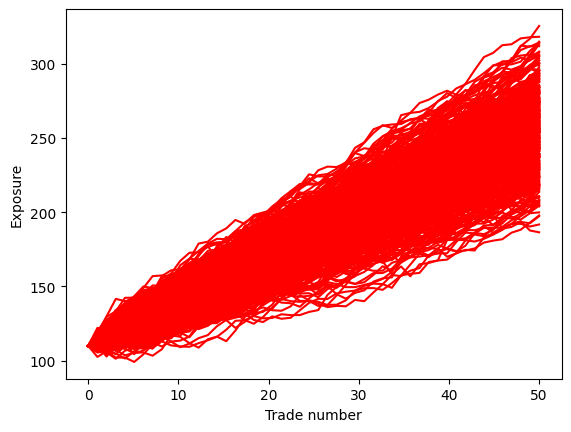

In [12]:

np.random.seed(2020)

X = np.random.uniform(MTM_Min,MTM_Max,10**5)

Y = [max(0,i) + addOnFactor * 10 * abs(i) for i in X]

# This monte carlo simluates the mean and variance, but maybe also show how it's done by hand as well !

mu = np.mean(Y)
standard_dev = np.std(Y)

dt = 1

print("Mean of distribution: " + str(mu) + "  Standard Deviation of distribution: " + str(standard_dev))
print("\n")
T = n  # T = Time <=> Trade 

m = int(T/dt)
t = np.linspace(0,T,m)

def run_sim():

    x = np.zeros(m)
    x[0] = MarkToMarket + 0.01 * Notional

    for i in range(m-1):
        # This is our ABM equation. There are more stochastic calculus notes on the paper. 
        x[i+1] = x[i] + mu*dt + standard_dev*np.random.normal(0,1)*np.sqrt(dt)
    
    return x

plt.figure()
for i in range(500):
    x = run_sim()

    plt.plot(t, x, 'r')


print("mu = ", mu)
print("sigma = ", standard_dev)
mu_T = mu*T
sigma_T = standard_dev ** 2 * T
print("Distribution of trades at trade 100 --> N( mu * t + X_0 , sigma^2 * t ) = N( " + str(mu*T + x[0]) + " , " + str(standard_dev ** 2 * T) + " )")
plt.xlabel("Trade number")
plt.ylabel("Exposure")
plt.show()



### Part 2: Percentage Growth relative to Brute Force Method
#### The alternative strategies by definition overestimate the exposure, but by how much ?
#### The code below investigate the growth on an interactive graph, where you can see how the strategies work for different positions


#### OPTIONAL: Perform a data clean to remove outliers in the percentage growth. 
Often when the trdae number is small, the rate of growth can be exponential, so we can remove them using the function below 

In [13]:
def remove_outliers(data, threshold = 2):

    # The growth in exposure from the baseline can be exceptionally high for a small number of trades (since we are going from 0% difference to, for instance, a 20% differnce depending on the impacts we use).
    # This function removes the outliers that impact our analysis of the graph, by using standard mean and variance approaches

    n = len(data)
    mean = np.mean(data)
    std_dev = np.std(data)
    cleaned_data = data.copy()

    for i in range(len(data)):

        if -(mean+threshold*std_dev) < data[i] < (mean+threshold*std_dev):
            cleaned_data[i] = data[i]
        else:
            if i == 0:
                neighbors = [data[j] for j in range(max(0, i+5), min(len(data), i+3)) if j != i]
                cleaned_data[i] = np.median(neighbors)
            elif i == len(data) - 1:
                continue
            else:
                # Method: use median and neighbours
                neighbors = [data[j] for j in range(max(0, i-2), min(len(data), i+3)) if j != i]
                cleaned_data[i] = np.median(neighbors)
    return cleaned_data
    

#### Step 1: Run the code below to simluate percentage growth

In [14]:
def simulation_exposure_growth(n, addon, MarkToMarket, Notional, MTM_Min, MTM_Max, lin=True, cons=False, avg=False, dataclean=False):


    bf_exposure_for_trade_i = []
    cons_exposure_for_trade_i = []
    lin_exposure_for_trade_i = []
    avg_exposure_for_trade_i = []

    for i in range(1,n):
        
        bf_list = []
        cons_list = []
        lin_list = []
        avg_list = []

        positions = get_position_impacts(i, MarkToMarket, Notional, MTM_Min, MTM_Max)
        
        singleposition = False

        NGR_BF = PSR_NGR(positions, addOnFactor, singleposition)
        NGR_Lin = PSR_Linear(positions, addOnFactor)
        NGR_Cons = PSR_Conservative(positions, addOnFactor)
        NGR_Avg = PSR_Average(positions, addOnFactor, n)


        bf_exposure_for_trade_i.append(NGR_BF)
        cons_exposure_for_trade_i.append(NGR_Cons)
        lin_exposure_for_trade_i.append(NGR_Lin)
        avg_exposure_for_trade_i.append(NGR_Avg)


    diff_cons = [(cons_exposure_for_trade_i[i]-bf_exposure_for_trade_i[i])/bf_exposure_for_trade_i[i] * 100 for i in range(len(bf_exposure_for_trade_i))]
    diff_lin = [(lin_exposure_for_trade_i[i]-bf_exposure_for_trade_i[i])/bf_exposure_for_trade_i[i] * 100 for i in range(len(bf_exposure_for_trade_i))]
    diff_avg = [(avg_exposure_for_trade_i[i]-bf_exposure_for_trade_i[i])/bf_exposure_for_trade_i[i] * 100 for i in range(len(bf_exposure_for_trade_i))]
        
    if dataclean == True:
        diff_cons = remove_outliers(diff_cons, 3)
        diff_lin = remove_outliers(diff_lin, 3)
        diff_avg = remove_outliers(diff_avg, 3)


    x = np.arange(1,n)

    plt.figure(figsize=(8, 5))
    plt.grid(True)

    if lin == True:
        plt.plot(x[int(n/100):],diff_lin[int(n/100):],'r', label="Linearisation")
    
    if cons == True:
        plt.plot(x,diff_cons,'b', label="Conservative")

    if avg == True:
        plt.plot(x,diff_avg,'g', label="Averages")

    plt.xlabel("# of trades")
    plt.ylabel("% Diff. from Brute Force")
    plt.legend()
    plt.show()

        

#### Run the code using the ipywidgets module

In [15]:
widgets.interact(simulation_exposure_growth, 
         n = widgets.Play(min = 20 , max = 800, step = 20, interval=200),
         addon = widgets.FloatSlider(min=0,max=1,step=0.01,value=0.01,description="AddOnFactor"),
         MarkToMarket = widgets.IntSlider(min=0,max=10000,step=100,value=1000,description="Base MTM"),
         Notional = widgets.IntSlider(min=0,max=1000000,step=1000,value=100000,description="Base Notional"),
         MTM_Min = widgets.IntSlider(min=-1000,max=-100,step=10,value=-10,description="MTM Min"),
         MTM_Max = widgets.IntSlider(min=100,max=1000,step=10,value=10,description="MTM Max"), 
)

interactive(children=(Play(value=20, description='n', interval=200, max=800, min=20, step=20), FloatSlider(val…

<function __main__.simulation_exposure_growth(n, addon, MarkToMarket, Notional, MTM_Min, MTM_Max, lin=True, cons=False, avg=False, dataclean=False)>

There are a few instances where the dataset produced causes the linearisation approach to go wayyy below, it seems that those same datasets cause the conservative and linearisation approach to go way higher, I need to investigate this more

HOWEVER, this seems to only happen when the mark to market is quite low, when the starting position is large, what happens is we get a linear growth of conservative and averages (averages connects to conservative more as number of trades increases)

INTERESTING OBSERVATION: For a large baseline, the averages strategy actually behaves exactly like the linear and conservative approach, whereas for a small baseline, it starts to act like the conservative approach. Why is that???